In [5]:
# Helpers

############################################################################################
# Falls JSON nicht fertig generiert wurde, wird json beim letzten vollständigen Block beendet.
# Gibt Json Objekt zurück
############################################################################################
def fixUnfinishedJson(output):

    import json
    try:
        ojson = json.loads(output)
        return ojson
    except json.decoder.JSONDecodeError:
        lastValidIndex = output.rfind("""}},""")

        lastValidIndex += len("""}},""")-1

        output = output[:lastValidIndex]
        output += """]}"""
        return json.loads(output)
    
############################################################################################
# Filtert aus gesamter KI-Ausgabe (string) die Antowort raus
############################################################################################
def findResponse(output):
    response= "### Response:"
    response_index = output.find(response)
    if response_index == -1:
        return output
    response_index += len(response)
    output = output[response_index:]
    return output

import json
import os
############################################################################################
# Gibt die nächste Versionsnummer zurück
############################################################################################
def get_next_version(fullpath):
    """
    Finds the next version number
    """
    
    # Split the path into directory and filename
    directory, full_file_name = os.path.split(fullpath)
    

    # Check if the directory exists, if not create it and return 0
    if not os.path.exists(directory):
        os.makedirs(directory)

    from pathlib import Path
    file = Path(f"{directory}\\{ID}_.json")
    if file.exists():

        j = json.load(file.open("r"))
        j["v"] = j["v"] + 1
        json.dump(j, file.open("w"))
        return j["v"]
    else:
        j = {"v": 1}
        json.dump(j, file.open("w"))
        return j["v"]

############################################################################################
# Gibt Dateiname und Speicherpfad zurück für organisiertes Speichern der Ergebnisse
############################################################################################
def getFilePath(name="", ext =""):
    return f"""{directory}{ID}_v{VERSION}_{name}{ext}"""

############################################################################################
# Generiert Samples aus Json Objekt
############################################################################################
def generateSamples(hlabsJson):
        import numpy
        sample_rate = 16000
        audio_arr = []

        for block in hlabsJson["sequence"]:
            if block["type"] == "v": # wemm Sinuswelle

                duration_in_seconds = block["data"]["dur"] / 1000
                ampitude = block["data"]["amp"]
                fequencie = block["data"]["freq"]

                t = numpy.linspace(0, duration_in_seconds, int(sample_rate *duration_in_seconds), endpoint=False)  # Time array
                audio_arr.extend(ampitude * numpy.sin(2 * numpy.pi * fequencie * t))  # Sine wave formula

            else: # wenn Pause
                duration_in_seconds = block["data"]["dur"] / 1000
                audio_arr.extend(numpy.zeros(int(sample_rate * duration_in_seconds)))
        return numpy.float32(audio_arr)

############################################################################################
# Visualisiert die Ausgabe (Json Objekt)
############################################################################################
def plotOutput(ojson):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    plt.figure().set_figwidth(20) 

    amplitudes = []
    frequencies = []
    times = []
    times.append(0)
    for block in ojson["sequence"]:
        if block["type"] == "v":
            amplitudes.append(block["data"]["amp"])
            frequencies.append(block["data"]["freq"])
        else:
            amplitudes.append(0)
            frequencies.append(0)
            if len(times) > 0:
                plt.axvspan(times[-1], times[-1] + block["data"]["dur"], color="green", alpha=0.5)
            else:
                plt.axvspan(0, block["data"]["dur"], color="green", alpha=1)
        if len(times) == 0:
            times.append(block["data"]["dur"])
        else:
            times.append(times[-1] + block["data"]["dur"])
    times_block_mid = []
    times_block_mid.append(times[0] - 0 / 2)

       
    line1 =plt.hlines(amplitudes, times[:-1], times[1:], color="blue",label="Amplitude")
    plt.ylabel("Amplitude")
    plt.xlabel("Zeit in Millisekunden")
    plt.legend(loc="upper right")
    plt.twinx()
    line2=plt.hlines(frequencies, times[:-1], times[1:], color="red",label="Frequenz")
    plt.ylabel("Frequenz in Hertz")
    plt.legend(handles=[line1, line2])
    plt.savefig(getFilePath(name="Blocks",ext=".png"))

############################################################################################
# Visualisiert Signal
############################################################################################
def plotOutputSignal(audio_arr):
    import numpy
    import matplotlib.pyplot as plt
    times = numpy.arange(0,len(audio_arr)/16,1/16)
    plt.figure().set_figwidth(20)
    plt.plot(times, audio_arr,label="Signal")
    plt.hlines([-1,1],0,times[-1],colors="red",label="Amplitudengrenzen")
    plt.xlabel("Zeit in Millisekunden")
    plt.legend()
    plt.savefig(getFilePath(name="Signal",ext=".png"))

############################################################################################
# Speichert Signal als wav-Datei
############################################################################################
def saveAsWav(audio_arr, sr):
    import scipy.io.wavfile
    filename = getFilePath(name="",ext=".wav")
    scipy.io.wavfile.write(filename, sr, audio_arr)
    return filename

def visualize(ojson):
    plotOutput(ojson)
    samples=generateSamples(ojson)
    plotOutputSignal(samples)
    # wav-Audio erstellen
    wavFile = saveAsWav(samples, 16000)

    # Audio anzeigen
    from IPython import display
    display.display(display.Audio(wavFile))




ID = "" #Wiedererkennung des Prompts (z.B ID = ID des Datensatzes aus dem der Prompt stammt)
VERSION = -1 #wird durch get_next_version() gesetzt (pro generierter Ausgabe)
directory = "..\\viblib\\colabGenerarions\\"

In [6]:
def countOfVBlocks(ojson):
    count = 0
    for block in ojson["sequence"]:
        if block["type"] == "v":
            count += 1
    return count
def countOfPBlocks(ojson):
    count = 0
    for block in ojson["sequence"]:
        if block["type"] == "p":
            count += 1
    return count
def pBlockDuration(ojson):
    for block in ojson["sequence"]:
        duration = 0
        if block["type"] == "p":
            duration += block["data"]["dur"]
def meanFrequency(ojson):
    frequencies = []
    durations = []

    for block in ojson["sequence"]:
        if block["type"] == "v":
            dur= block["data"]["dur"]
            freq = block["data"]["freq"]
            frequencies.append(freq)
            durations.append(dur)

    return sum(frequencies*durations)/sum(durations)
def meanAmplitude(ojson):
    amplitudes = []
    durations = []

    for block in ojson["sequence"]:
        if block["type"] == "v":
            dur= block["data"]["dur"]
            amp = block["data"]["amp"]
            amplitudes.append(amp)
            durations.append(dur)

    return sum(amplitudes*durations)/sum(durations)

def standardDeviationAmplitude(json):
    mean = meanAmplitude(ojson)
    
def compareDistribution(refJson,genJson,feature):
    import numpy as np
    from scipy.stats import gaussian_kde
    import matplotlib.pyplot as plt

    refDate = []
    for block in refJson["sequence"]:
        if (feature == "amp" or feature == "freq") and block["type"] == "p":

            refDate.append(0)
        else:
            refDate.append(block["data"][feature])

    genData = []
    for block in genJson["sequence"]:
        if (feature == "amp" or feature == "freq") and block["type"] == "p":
            genData.append(0)
        else:
            genData.append(block["data"][feature])
    
    refKDE = gaussian_kde(refDate)
    genKDE = gaussian_kde(genData)

    # Gemeinsamer Wertebereich für die KDE-Plots
    x_vals = np.linspace(min(min(refDate), min(genData)), max(max(refDate), max(genData)), 1000)

    # Berechnung der Wahrscheinlichkeitsdichte für beide KDEs
    refPDF = refKDE(x_vals)
    genPDF = genKDE(x_vals)

    # plt.figure()
    # plt.plot(x_vals, refPDF, label='Dichtefunktion Referenz', color='blue')
    # plt.plot(x_vals, genPDF, label='Dichtefunktion Generiert', color='red')
    # plt.fill_between(x_vals, np.minimum(refPDF, genPDF), color='purple', alpha=0.5, label='Überlappende Fläche')
    # plt.title('Wahrscheinlichkeitsdichtefunktionen und Überlappung ' + feature)
    # plt.xlabel('Werte')
    # plt.ylabel('Dichte')
    # plt.legend()

    # Berechnung der überlappenden Fläche
    overlap_area = np.trapz(np.minimum(refPDF, genPDF), x_vals)
    print(f"Überlappende Fläche der beiden Dichtefunktionen bei {feature}: {overlap_area}")
    return overlap_area

def normDTW(refJson,genJson,feature):
    from dtaidistance import dtw
    import numpy as np
    import matplotlib.pyplot as plt
    ### Zeitreihen erstellen
    refSamples = []
    for block in refJson["sequence"]:
        if block["type"] == "p":
            refSamples += [0] * ((int)(block["data"]["dur"]))
        else:
            refSamples += [block["data"][feature]]*((int)(block["data"]["dur"]))

    genSamples = []
    for block in genJson["sequence"]:
        if block["type"] == "p":
            genSamples += [0] * ((int)(block["data"]["dur"]))
        else:
            genSamples += [block["data"][feature]]*((int)(block["data"]["dur"]))
    
    # Normalisierten
    genMean=np.mean(genSamples)
    genSamples= [value - genMean for value in genSamples]

    refMean=np.mean(refSamples)
    refSamples= [value - refMean for value in refSamples]

    # plt.figure()
    # plt.title("DTW")
    # plt.plot(genSamples)
    # plt.plot(refSamples)

    #dtw
    distance = dtw.distance(refSamples,genSamples)
    print(f"Die DTW Distanz beträgt bei {feature} {distance}")
    return distance


    

def calcMetrics(refJson,genJson,results):
    #TODO
    if "compareDistribution" not in results:
        results["compareDistribution"] = {"freq": [], "amp": [], "dur": []}
        results["distance"] = {"freq":[], "amp":[]}
    for feature in results["compareDistribution"]:
        results["compareDistribution"][feature].append(compareDistribution(refJson,genJson,feature))
    for feature in results["distance"]:
        results["distance"][feature].append(normDTW(refJson,genJson,feature))







Datensatz 0
Prompt: 
Create a regular, smooth, discontinuous, and soft vibrotactile pattern. This pattern should evoke a calm, comfortable, natural, predictable, and familiar feeling, reminiscent of a heartbeat, pawing, an animal, or gentle tapping. Use this pattern to signal a reminder, indicate a low battery, or prompt the user to slow down.


Testdaten:

{"sequence": [{"type": "p", "data": {"dur": 26}}, {"type": "v", "data": {"amp": 0.1, "freq": 131, "form": "sine", "dur": 26}}, {"type": "v", "data": {"amp": 0.14, "freq": 131, "form": "sine", "dur": 26}}, {"type": "v", "data": {"amp": 0.2, "freq": 131, "form": "sine", "dur": 26}}, {"type": "v", "data": {"amp": 0.28, "freq": 131, "form": "sine", "dur": 26}}, {"type": "v", "data": {"amp": 0.36, "freq": 131, "form": "sine", "dur": 26}}, {"type": "v", "data": {"amp": 0.44, "freq": 131, "form": "sine", "dur": 26}}, {"type": "v", "data": {"amp": 0.52, "freq": 131, "form": "sine", "dur": 26}}, {"type": "v", "data": {"amp": 0.59, "freq"

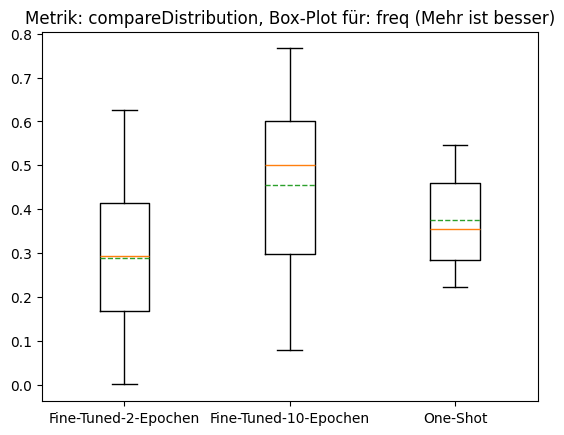

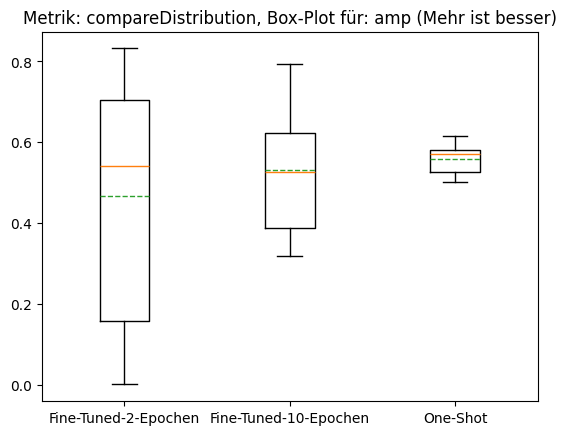

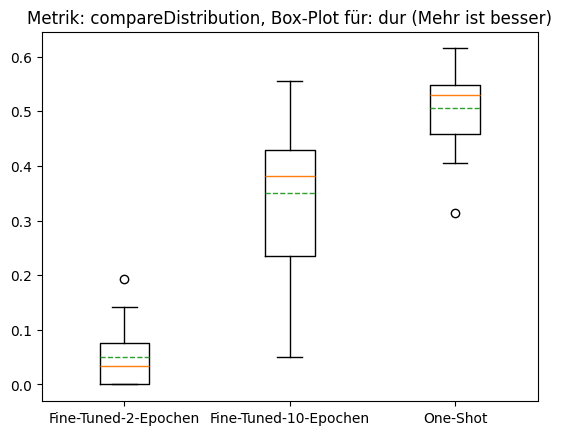

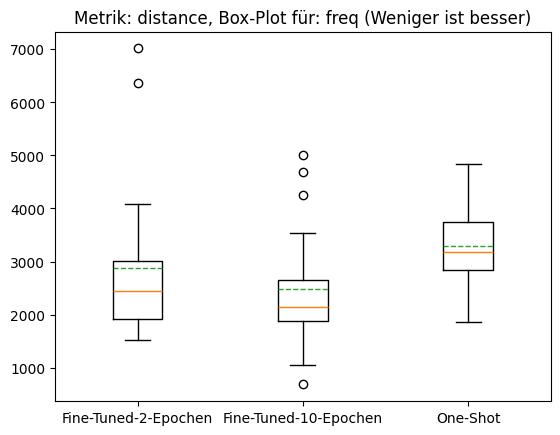

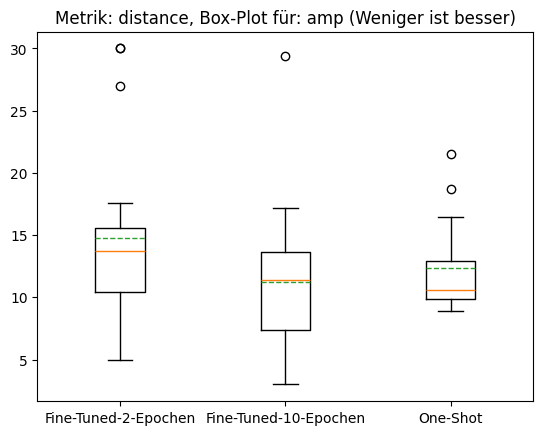

In [8]:
import json
import numpy

path = r"C:\Users\Domin\Desktop\testNr3_v3_tests.json"

endOfText="<|end_of_text|>"

with open(path, "r") as f:
    modelletests = json.load(f)

allTestsResults = {}
for tests in modelletests:
    results = {}
    for i, dataset in enumerate(modelletests[tests]):

        print("\n\n\n\nDatensatz",i)
        print("Prompt:",dataset["prompt"])
        print("Testdaten:")
        referenceData=findResponse(dataset["referenceData"])
        referenceData= referenceData[:-len(endOfText)]
        refJson = json.loads(referenceData)

        ID = f"Data{i}"
        VERSION = 0

        #visualize(refJson)
        # calcMetrics(refJson)


        for j, data in enumerate(dataset["generatedData"]):


            VERSION = j+1

            response=findResponse(data)
            print(response)
            ojson=fixUnfinishedJson(response)
            print(f"Generierung {j}:")


            #visualize(ojson)

            calcMetrics(refJson,ojson, results)

    allTestsResults[tests] = results
import numpy as np
import matplotlib.pyplot as plt

for model in allTestsResults:
    print("## Auswertung")
    for key in allTestsResults[model]:
        for feature in allTestsResults[model][key]:
            print("Modell:", model)
            print(f"Metrik:{key} Durchschnitt von {feature}: {np.mean(allTestsResults[model][key][feature])}")
            print(f"Metrik:{key} Standartabweichung von {feature}: {np.std(allTestsResults[model][key][feature])}")

allTestsTesultsPerMerrik = {}
allTestsLabels = []
for model in allTestsResults:
    for key in allTestsResults[model]:
        for feature in allTestsResults[model][key]:

            if key not in allTestsTesultsPerMerrik:
                allTestsTesultsPerMerrik[key] = {}
            if feature not in allTestsTesultsPerMerrik[key]:
                allTestsTesultsPerMerrik[key][feature] = []
            
            allTestsTesultsPerMerrik[key][feature].append(allTestsResults[model][key][feature])
    allTestsLabels.append(model)

print("Labels", allTestsLabels)
print("allTestsTesultsPerMerrik",allTestsTesultsPerMerrik)      

for key in allTestsTesultsPerMerrik:
    for feature in allTestsTesultsPerMerrik[key]:
        moreOreLessIsBetter = ""
        if key == "distance": moreOreLessIsBetter="(Weniger ist besser)"
        else: moreOreLessIsBetter="(Mehr ist besser)"
        plt.figure()
        plt.title(f"Metrik: {key}, Box-Plot für: {feature} {moreOreLessIsBetter}")
        plt.boxplot(allTestsTesultsPerMerrik[key][feature],showmeans=True, meanline=True)
        plt.xticks([i + 1 for i in range(len(allTestsLabels))], allTestsLabels)
        
            




    
    

# Graphen generieren

In [4]:
# path = r"C:\Users\Domin\OneDrive\HTW\Bachelorarbeit\one-shot-instructed.json"
# with open(path, "r") as f:
#     generatoins = json.load(f)

# for i,data in enumerate(generatoins):
#     print(data)
#     ID = i
#     if i%3 == 0:
#         continue
#     visualize(data)
    